In [1]:
###########import packages##########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn.linear_model import BayesianRidge
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import ExtraTreeClassifier
from sklearn import linear_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import lightgbm
import catboost
import xgboost
#import shap
from scipy import interp
#import seaborn as sns
from catboost import *
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score
#%matplotlib
###########wrapping root mean square error for later calls##########
def compute_mae_mse_rmse(target,prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])
    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val)  # target-prediction之差平方
        absError.append(abs(val))  # 误差绝对值
    mae=sum(absError)/len(absError)  # 平均绝对误差MAE
    mse=sum(squaredError)/len(squaredError)  # 均方误差MSE
    RMSE=np.sqrt(sum(squaredError)/len(squaredError))
    R2=r2_score(target,prediction)
    return mae,mse,RMSE,R2
###########loading data##########
fdata=pd.read_csv('database_filled_CD.csv',encoding="gbk")
raw_data=fdata.loc[:,[
                      'Operating Temperature (℃)',#0
                      'Flow Rate (mL min-1)',#1    
                      'Active Area (cm2)', #2
                      'Ir wt. %',#3
                      'Ru wt.%',#4
                      'O wt. %',#5
                      'I/C in Anode',#6
                      'Pt wt. %',#7
                      'I/C in Cathode',#8  
                      'Anode Precious Metal Loading (mg cm-2 Ir/Ru/Pt/Pd)',#9
                      'Cathode Precious Metal Loading (mg cm-2 Pt/Pd)',#10
                      'Membrane Thickness (μm)',#11
                      'EW'#12
                        ]]
###########train test splitting##########
raw_param=raw_data.iloc[:,0:13]
print('ready')

ready


In [2]:
CD19=fdata.loc[:,['Current at 1.9 V']]

In [3]:
def summarize(list1):
    total=0
    for ele in range(0, len(list1)):
        total = total + list1[ele]
    return total

In [4]:
def gridsearch(model,param,algorithm_name):
    grid = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-1)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    result = best_model.predict(X_test)
    x_prediction_07=result
    y_real_07=y_test[:,0]
    x_prediction_07_series=pd.Series(x_prediction_07)
    y_real_07_series=pd.Series(y_real_07)
    
    result_train = best_model.predict(X_train)
    x_prediction_07_train=result_train
    y_real_07_train=y_train[:,0]
    x_prediction_07_series_train=pd.Series(x_prediction_07_train)
    y_real_07_series_train=pd.Series(y_real_07_train)
    
    ###########evaluating the regression quality##########
    corr_ann = round(x_prediction_07_series.corr(y_real_07_series), 5)
    error_val= compute_mae_mse_rmse(x_prediction_07,y_real_07)
    
    corr_ann_train = round(x_prediction_07_series_train.corr(y_real_07_series_train), 5)
    error_val_train= compute_mae_mse_rmse(x_prediction_07_train,y_real_07_train)
    
    print(algorithm_name)
    print(best_model.feature_importances_)
    print('Best Regressor:',grid.best_params_,'Best Score:', grid.best_score_)
    print(error_val,'TEST R2',error_val[3],'TEST CORR',corr_ann)
    print(error_val_train,'TRAIN R2',error_val_train[3],'TRAIN CORR',corr_ann_train)
    x_y_x=np.arange(0,6.5,0.1)
    x_y_y=np.arange(0,6.5,0.1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x_prediction_07,y_real_07,color='red',label=algorithm_name+' Test Set',alpha=0.75)
    ax.scatter(x_prediction_07_train,y_real_07_train,color='blue',label=algorithm_name+' Training Set',alpha=0.25,marker="^")
    ax.plot(x_y_x,x_y_y)
    plt.legend()
    plt.xlabel(u"Predicted_Current_Density (mA cm^-2)@1.9V (vs. RHE)")
    plt.ylabel(u"Real_Current_Density (mA cm^-2)@1.9V (vs. RHE)")
    plt.savefig('CD19 SEL %s.png' %algorithm_name)
    print('finished')

In [5]:
seed=8
X_train, X_test, y_train, y_test = train_test_split(raw_param, CD19, test_size=.15,random_state=seed)

In [6]:
train=pd.concat([X_train,y_train],axis=1)
train.to_csv('REG19_train.csv')
test=pd.concat([X_test,y_test],axis=1)
test.to_csv('REG19_test.csv')

In [6]:
from catboost import *
import shap
def shap_plot(model,param,algorithm_name):
    print(algorithm_name)
    SHAP_INPUT=raw_data.iloc[:,0:13]
    SHAP_OUTPUT=CD19
    grid = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-100)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    X_SHAP=SHAP_INPUT.values.astype(np.float32)
    y_SHAP=SHAP_OUTPUT
    if algorithm_name=='CatBoost':
        shap_values = best_model.get_feature_importance(Pool(X_SHAP,y_SHAP), type="ShapValues")
        shap_values=shap_values[:,:-1]
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)
    elif algorithm_name=='Random Forest' or algorithm_name=='Extra Tree'or algorithm_name=='Decision Tree'or algorithm_name=='AdaBoost':
        explainer = shap.TreeExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)
    else:
        explainer = shap.TreeExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)

In [7]:
# ##########LGBM gridsearch CV for best hyperparameter##########
# model_LightGBMRegressor=lightgbm.LGBMRegressor(random_state=1,verbose=-1)
# param_light = {
# 'boosting_type':['gbdt','rf'],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'n_estimators':[50,100,200,400],
# 'max_depth':[5,7,9,11,13,-1],
# 'reg_alpha':[0,0.001,0.01,0.0001,0.00001],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
# }
# gridsearch(model_LightGBMRegressor,param_light,'LightGBM')

# ##########XGBoost gridsearch CV for best hyperparameter##########
# model_XGBRegressor=xgboost.XGBRegressor(objective='reg:squarederror',random_state=1,verbosity=0)
# param_xg = {
# 'booster':['gbtree'],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'n_estimators':[100,200,400],
# 'max_depth':[5,7,9,11,13],
# 'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'reg_alpha':[0,0.001,0.01,0.0001,0.00001],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
# }
# gridsearch(model_XGBRegressor,param_xg,'XGBoost')

# ##########CatBoost gridsearch CV for best hyperparameter##########
# model_CatRegressor=catboost.CatBoostRegressor(random_state=1,verbose=0)
# param_cat = {
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5],
# 'n_estimators':[50,100,200,400],
# "boosting_type":["Plain"],
# 'max_depth':[5,7,9,11],
# 'subsample':[0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
# }
# gridsearch(model_CatRegressor,param_cat,'CatBoost')


# ###########GradientBoost gridsearch CV for best hyperparameter##########
# model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(random_state=1)
# ###########defining the parameters dictionary##########
# param_GB = {
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'n_estimators':[50,100,200,400],
# 'max_depth':[3,5,7,9,11,13,16],
# 'criterion':['friedman_mse','mae','mse'],
# 'max_features':['auto','sqrt','log2'],
# 'loss':['ls', 'lad', 'huber', 'quantile']
# }
# gridsearch(model_GradientBoostingRegressor,param_GB,'GradientBoost')

# ###########RandomForest gridsearch CV for best hyperparameter##########
# model_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=1)
# ###########defining the parameters dictionary##########
# param_RF = {
# 'n_estimators':[50,100,200,400,None],
# 'max_depth':[3,5,7,9,11,None],
# 'criterion':['mse','mae'],
# 'max_features':['auto','sqrt','log2']
# }
# gridsearch(model_RandomForestRegressor,param_RF,'Random Forest')


# ###########Extra Tree gridsearch CV for best hyperparameter##########
# model_ExtraTreeRegressor = ExtraTreeRegressor(random_state=1)
# param_ET = {
# 'max_depth':[5,6,7,8,9,10,11,None],
# 'max_features':['auto','sqrt','log2'],
# 'criterion' : ["mse", "friedman_mse", "mae"],
# 'splitter' : [ "best",'random']
# }
# gridsearch(model_ExtraTreeRegressor,param_ET,'Extra Tree')


# ###########Decision Tree gridsearch CV for best hyperparameter##########
# model_DecisionTreeRegressor = tree.DecisionTreeRegressor(random_state=1)
# param_DT = {
# 'max_depth':[5,6,7,8,9,10,11,None],
# 'max_features':['auto','sqrt','log2'],
# 'criterion' : ["mse", "friedman_mse", "mae"],
# 'splitter' : [ "best",'random']
# }
# gridsearch(model_DecisionTreeRegressor,param_DT,'Decision Tree')


# ###########AdaBoost gridsearch CV for best hyperparameter##########
# model_AdaBoostRegressor = ensemble.AdaBoostRegressor(random_state=1)
# param_Ada = {
# 'n_estimators':[50,100,200,400,800],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'loss':['linear', 'square', 'exponential']
# }
# gridsearch(model_AdaBoostRegressor,param_Ada,'AdaBoost')

Converting column-vector to 1d array


LightGBM
[191 144 125  82  19  77 268 120 177 260 143  89  55]
Best Regressor: {'boosting_type': 'gbdt', 'learning_rate': 0.14, 'max_depth': 13, 'n_estimators': 100, 'reg_alpha': 0.0001, 'reg_lambda': 0.01, 'subsample': 0.4} Best Score: 0.7302067475236947
(0.3380390083108833, 0.2903368367600522, 0.538829135032667, 0.8534552921729824) TEST R2 0.8534552921729824 TEST CORR 0.93125
(0.24839470785218912, 0.2249502443796967, 0.47428919909660255, 0.8668643801080482) TRAIN R2 0.8668643801080482 TRAIN CORR 0.94254
finished


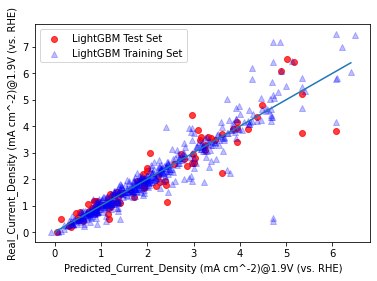

In [8]:
##########LGBM gridsearch CV for best hyperparameter##########
model_LightGBMRegressor=lightgbm.LGBMRegressor(random_state=1,verbose=-1)
param_light = {
'boosting_type':['gbdt'],
'learning_rate':[0.14],
'subsample':[0.4],
'n_estimators':[100],
'max_depth':[13],
'reg_alpha':[0.0001],
'reg_lambda':[0.01]
}
gridsearch(model_LightGBMRegressor,param_light,'LightGBM')

In [9]:
%matplotlib
shap_plot(model_LightGBMRegressor,param_light,'LightGBM')

Using matplotlib backend: Qt5Agg
LightGBM


Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array


[0.39000548 0.05640597 0.07733236 0.04689952 0.03708293 0.10406683
 0.2018587  0.09002143 0.19950705 0.1313749  0.06853663 0.53341738
 0.06339456]


In [10]:
##########XGBoost gridsearch CV for best hyperparameter##########
model_XGBRegressor=xgboost.XGBRegressor(objective='reg:squarederror',random_state=1,verbosity=0)
param_xg = {
'booster':['gbtree'],
'learning_rate':[0.01],
'n_estimators':[400],
'max_depth':[9],
'subsample':[0.5],
'reg_alpha':[0.001],
'reg_lambda':[0.0001]
}
gridsearch(model_XGBRegressor,param_xg,'XGBoost')

XGBoost
[0.03244147 0.01860454 0.02507334 0.03062418 0.03942534 0.07795683
 0.03588757 0.04384854 0.08186679 0.03474449 0.04612738 0.449539
 0.08386064]
Best Regressor: {'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 400, 'reg_alpha': 0.001, 'reg_lambda': 0.0001, 'subsample': 0.5} Best Score: 0.7277143496184894
(0.2793914918050175, 0.1757773679753047, 0.4192581161710584, 0.9105584442353368) TEST R2 0.9105584442353368 TEST CORR 0.95875
(0.17271541087565961, 0.13835282294259443, 0.3719580929924693, 0.918569019534084) TRAIN R2 0.918569019534084 TRAIN CORR 0.96609
finished


In [11]:
shap_plot(model_XGBRegressor,param_xg,'XGBoost')

XGBoost


 93%|=================== | 539/578 [00:15<00:01]       

[0.34788017 0.06424545 0.05301051 0.03934802 0.04260696 0.07674515
 0.13972624 0.06971178 0.16450906 0.09172396 0.08649223 0.51664172
 0.11505874]


In [13]:
##########CatBoost gridsearch CV for best hyperparameter##########
model_CatRegressor=catboost.CatBoostRegressor(random_state=1,verbose=0)
param_cat = {

'max_depth':[11],
'boosting_type':['Plain'],
'subsample':[0.45],
'reg_lambda':[1e-05]
}
gridsearch(model_CatRegressor,param_cat,'CatBoost')

CatBoost
[18.53646816  5.086477    4.0316847   4.08702213  2.32303606  6.51383143
  8.92121888  5.46978006 10.86165724  6.87071215  8.02658817 15.69489313
  3.5766309 ]
Best Regressor: {'boosting_type': 'Plain', 'max_depth': 11, 'reg_lambda': 1e-05, 'subsample': 0.45} Best Score: nan
(0.24569425275832155, 0.13562149977117982, 0.36826824431544436, 0.9327039689049091) TEST R2 0.9327039689049091 TEST CORR 0.96847
(0.09122957569721384, 0.1163684086609736, 0.3411281411155837, 0.9380060624572879) TRAIN R2 0.9380060624572879 TRAIN CORR 0.97055
finished


In [14]:
shap_plot(model_CatRegressor,param_cat,'CatBoost')

CatBoost
[0.30892971 0.08444802 0.06412259 0.05273128 0.04869042 0.05738286
 0.14183547 0.06898965 0.15740838 0.09152151 0.12845511 0.35963173
 0.0988195 ]


In [15]:
###########GradientBoost gridsearch CV for best hyperparameter##########
model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(random_state=1)
###########defining the parameters dictionary##########
param_GB = {
'learning_rate':[0.04],
'n_estimators':[200],
'max_depth':[7],
'criterion':['mse'],
'max_features':['sqrt'],
'loss':['ls']
}
gridsearch(model_GradientBoostingRegressor,param_GB,'GradientBoost')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoost
[0.1560969  0.05018436 0.03187356 0.02935757 0.01268217 0.06635627
 0.12807157 0.02531097 0.08749825 0.05737603 0.10920227 0.1976236
 0.04836647]
Best Regressor: {'criterion': 'mse', 'learning_rate': 0.04, 'loss': 'ls', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200} Best Score: 0.7455078842936924
(0.2921022011644976, 0.2152056439070898, 0.46390262330266013, 0.8873829467211111) TEST R2 0.8873829467211111 TEST CORR 0.94933
(0.1256188141216428, 0.12405350056460251, 0.35221229473799254, 0.9318806441128653) TRAIN R2 0.9318806441128653 TRAIN CORR 0.96869
finished


In [16]:
shap_plot(model_GradientBoostingRegressor,param_GB,'GradientBoost')

GradientBoost


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.36382118 0.07073567 0.05671294 0.04027638 0.02273881 0.0680691
 0.17704309 0.04546058 0.13493506 0.09660088 0.13661221 0.39173904
 0.14316712]


In [17]:
###########RandomForest gridsearch CV for best hyperparameter##########
model_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=1)
###########defining the parameters dictionary##########
param_RF = {
'n_estimators':[100],
'max_depth':[None],
'criterion':['mse'],
'max_features':['sqrt']
}
gridsearch(model_RandomForestRegressor,param_RF,'Random Forest')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest
[0.1440177  0.05641151 0.03678755 0.03853085 0.01369627 0.05453514
 0.12079209 0.04014947 0.08218646 0.06377402 0.12386411 0.18027775
 0.04497708]
Best Regressor: {'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100} Best Score: 0.7344687689779733
(0.3557730656074957, 0.2834210047508347, 0.5323729940096837, 0.833572458236127) TEST R2 0.833572458236127 TEST CORR 0.9338
(0.19657205551592605, 0.15637576008613227, 0.3954437508497666, 0.9048804026736238) TRAIN R2 0.9048804026736238 TRAIN CORR 0.96187
finished


In [18]:
shap_plot(model_RandomForestRegressor,param_RF,'Random Forest')

Random Forest


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[0.3020276  0.08203357 0.04646176 0.04061589 0.03032642 0.05710142
 0.14666839 0.04640907 0.11076043 0.06718095 0.15091196 0.35412608
 0.09231667]


In [19]:
###########Extra Tree gridsearch CV for best hyperparameter##########
model_ExtraTreeRegressor = ExtraTreeRegressor(random_state=1)
param_ET = {
'max_depth':[10],
'max_features':['auto'],
'criterion' : ["mse"],
'splitter' : [ 'random']
}
gridsearch(model_ExtraTreeRegressor,param_ET,'Extra Tree')

Extra Tree
[0.16135697 0.04056902 0.06224201 0.05063833 0.07545013 0.06439613
 0.0482466  0.01912781 0.0500974  0.02736425 0.01579713 0.3300824
 0.05463184]
Best Regressor: {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'splitter': 'random'} Best Score: 0.6409051779937356
(0.4558520489320369, 0.5191883334644237, 0.720547245823911, 0.783977782607602) TEST R2 0.783977782607602 TEST CORR 0.88966
(0.2734214485666185, 0.24523129366175128, 0.4952083335948127, 0.8606167344808094) TRAIN R2 0.8606167344808094 TRAIN CORR 0.93684
finished


In [21]:
shap_plot(model_ExtraTreeRegressor,param_ET,'Extra Tree')

Extra Tree
[0.33338442 0.09508187 0.14065629 0.10072526 0.20313122 0.11207465
 0.05659234 0.04863507 0.08686851 0.08607742 0.04190478 0.51457893
 0.15472053]


In [22]:
###########Decision Tree gridsearch CV for best hyperparameter##########
model_DecisionTreeRegressor = tree.DecisionTreeRegressor(random_state=1)
param_DT = {
'max_depth':[10],
'max_features':['auto'],
'criterion' : ["mse"],
'splitter' : [ 'random']
}
gridsearch(model_DecisionTreeRegressor,param_DT,'Decision Tree')

Decision Tree
[0.16135697 0.04056902 0.06224201 0.05063833 0.07545013 0.06439613
 0.0482466  0.01912781 0.0500974  0.02736425 0.01579713 0.3300824
 0.05463184]
Best Regressor: {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'splitter': 'random'} Best Score: 0.6409051779937356
(0.4558520489320369, 0.5191883334644237, 0.720547245823911, 0.783977782607602) TEST R2 0.783977782607602 TEST CORR 0.88966
(0.2734214485666185, 0.24523129366175128, 0.4952083335948127, 0.8606167344808094) TRAIN R2 0.8606167344808094 TRAIN CORR 0.93684
finished


In [23]:
shap_plot(model_DecisionTreeRegressor,param_DT,'Decision Tree')

Decision Tree
[0.33338442 0.09508187 0.14065629 0.10072526 0.20313122 0.11207465
 0.05659234 0.04863507 0.08686851 0.08607742 0.04190478 0.51457893
 0.15472053]


In [24]:
###########AdaBoost gridsearch CV for best hyperparameter##########
model_AdaBoostRegressor = ensemble.AdaBoostRegressor(random_state=1)
param_Ada = {
'n_estimators':[400],
'learning_rate':[0.12],
'loss':['exponential']
}
gridsearch(model_AdaBoostRegressor,param_Ada,'AdaBoost')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


AdaBoost
[0.14877308 0.01424838 0.00720595 0.03580418 0.0058349  0.06172016
 0.14378034 0.01385015 0.13114588 0.03092579 0.03504662 0.3232472
 0.04841739]
Best Regressor: {'learning_rate': 0.12, 'loss': 'exponential', 'n_estimators': 400} Best Score: 0.5863480578613744
(0.7024364263898497, 0.790436489961723, 0.8890649526112943, 0.1397217495761348) TEST R2 0.1397217495761348 TEST CORR 0.8154
(0.6346464890162536, 0.6815952146326156, 0.825587799469333, 0.27405610192896146) TRAIN R2 0.27405610192896146 TRAIN CORR 0.82575
finished


In [25]:
shap_plot(model_AdaBoostRegressor,param_Ada,'AdaBoost')

AdaBoost


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.23219253 0.04645457 0.00629148 0.02399916 0.02641353 0.05097933
 0.22131431 0.01770779 0.1846446  0.02861783 0.02828969 0.41936861
 0.07310821]
